In [261]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split

In [262]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import pandas as pd
from PIL import Image
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay

In [263]:
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Functions

In [264]:
class Classifier(pl.LightningModule):
    def __init__(self, pos_weight: torch.Tensor = torch.Tensor(1),
                 optim_momentum: float = 0.2, optim_weight_decay: float = 1e-5,
                 optim_lr: float = 0.01):
        """
        Args:
            pos_weight (tensor): weighting of positive class loss to negative class loss
            optim_momentum (float) : SGD momentum
            optim_weight_decay (float) : Model weight decay (SGD)
            optim_lr (float) : Initial SGD learning rate
        """
        super(Classifier, self).__init__()
        self.model = models.resnet18(pretrained=False)
        # change 1st conv layer from 3 channel to 1 channel
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        #change to single output
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)
        
        ################ ADDED IN POSITIVE CLASS WEIGHTING
        self.pos_weight = pos_weight
        self.BCELoss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        self.sigmoid = nn.Sigmoid()
        
        ################ SGD PARAMETERS
        self.optim_momentum = optim_momentum
        self.optim_weight_decay = optim_weight_decay
        self.optim_lr = optim_lr
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        ################ REPLACED ADAM WITH SGD
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.optim_lr,
                                    momentum=self.optim_momentum,
                                    weight_decay=self.optim_weight_decay)
        return optimizer
    
    def BCE_loss(self, logits, labels):
        return self.BCELoss(logits, labels.float())
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)   # we already defined forward and loss in the lightning module. We'll show the full code next
        logits = torch.flatten(logits)
        loss = self.BCE_loss(logits, y)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        logits = torch.flatten(logits)
        loss = self.BCE_loss(logits, y)
        self.log('val_loss', loss)
        
    def predict(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

In [265]:
class CXRDataset(Dataset):
    def __init__(self, excel_path: str = "./", img_dir: str = "./",
                 img_brt_std: float = 0.10448302, transform_type: str = 'train'):
        """
        Args:
            excel_path (string): Path to excel file with ids and labels.
            img_dir (string): Directory with all the png images.
            img_brt_std (float): Standard deviation of brightness of training dataset.
            transform_type (string) : 'train' or 'predict' - whether to perform data augmentation or not
        """
        self.dataset = self.prepare_dataset(excel_path)
        self.img_dir = img_dir
        self.img_brt_std = img_brt_std
        
        ################ ADDED IN TRAIN/PREDICT TRANSFORM OPTION
        if transform_type == 'train':
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=img_brt_std),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
        elif transform_type == 'predict':
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])   
        
    def prepare_dataset(self, excel_path):
        df = pd.read_excel(excel_path)
        df = df.sort_values(by='Abnormal', ascending=False)
        df = df.drop_duplicates(subset="image_id", keep="first")
        df = df.sample(frac=1).reset_index(drop=True)
        return df
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataset['image_id'].iloc[idx] + '.png')
        image = Image.open(img_path)
        image = self.transform(image)
        ################ LABEL IS NOW NODULE/MASS
        label = self.dataset['Nodule/Mass'].iloc[idx]
        uuid = self.dataset['image_id'].iloc[idx]
        return image, label


In [266]:
class DataModule(pl.LightningDataModule):
    def __init__(self, img_dir: str = "./", train_file: str = "./",
                 val_file: str="./", batch_size: int = 24):
        """
        Args:
            img_dir (string): Directory with all the png images.
            train_file (string): path to train image excel
            val_file (string): path to validation image excel
            batch_size (int): batch size for training
        """
        super().__init__()
        self.img_dir = img_dir
        self.train_file = train_file
        self.val_file = val_file
        self.batch_size = batch_size
    
    def prepare_data(self):
        self.train_data = CXRDataset(self.train_file, self.img_dir, transform_type='train')
        self.val_data = CXRDataset(self.val_file, self.img_dir, transform_type='predict')
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)
        

In [267]:
def display_raw_image(img_file: str, img_dir: str = 'imgs/'):
    """ Displays an X-ray image directly from a path
    Args:
        img_dir (string) : directory containing images
        img_file (string) : image file name
    """
    img_path = os.path.join('imgs/', img_file)
    image = Image.open(img_path)
    return plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    
def display_dataset_image(dataset: CXRDataset, img_num: int):
    """ Displays an X-ray image from a CXRDataset
    Args:
        dataset (CXRDataset) : image dataset
        img_num (int) : image element to be displayed
    """
    return plt.imshow(dataset.train_data[img_num][0].squeeze(), cmap='gray', vmin=-1, vmax=1)

In [268]:
def validate(model: Classifier, data_loader: DataLoader):
    """ Generates model predictions using a dataloader
    Args:
        model (Classifier) : computer vision model generating predictions
        data_loader (DataLoader) : dataloader to iterate over dataset
    """
    labels = []
    pred_list = []
    
    for x, y in data_loader:
        preds = model.predict(x)
        labels += list(y.detach().cpu().numpy())
        pred_list += list(preds.detach().cpu().numpy())
        
    return labels, pred_list

In [269]:
def analysis(labels: list, pred_list: list, threshold: float = 0.5, f_beta: float = 1):
    """ Analyses model performance and returns a variety of metrics
    Args:
        labels (list) : list of binary integer labels
        pred_list (list) : list of prediction logits
        threshold (float) : threshold to define decision boundary
        f_beta (float) : weighting of recall vs precision in f score
    """
    results = {}
    results['fpr'], results['tpr'], results['thresholds'] = metrics.roc_curve(labels, pred_list)
    results['auc'] = metrics.auc(results['fpr'], results['tpr'])
    
    
    ################ ADDED IN CALCULATIONS FOR RECALL, PRECISION, FSCORE AND CONFUSION MATRIX
    pred_class_list = []
    for logit in pred_list:
        if logit >= threshold:
            pred_class = 1
        else:
            pred_class = 0
        pred_class_list.append(pred_class)
    
    prfs = metrics.precision_recall_fscore_support(labels, pred_class_list, beta=f_beta)
    results['precision'], results['recall'], results['fscore'], results['support'] = prfs
    
    results['confusion_matrix'] = metrics.confusion_matrix(labels, pred_class_list)
    
    return results

def plot_confusion_matrix(confusion_matrix: np.ndarray):
    """
    confusion_matrix (numpy.ndarray) : sklearn generated confusion matrix
    """
    
    ax = plt.subplot()
    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Normal', 'Nodule/Mass']); ax.yaxis.set_ticklabels(['Normal', 'Nodule/Mass']);


In [270]:
def get_brightness_means(img_dataset: CXRDataset):
    """ Returns mean brightness values per image in a dataset
    Args:
        img_dataset (CXRDataset) : image dataset to be analysed
    """
    brightness_means = []
    for sample in img_dataset:
        img = sample[0]
        brightness_means.append(img.mean())
        
    return brightness_means

## Brightness Analysis

In [271]:
dataset = DataModule('imgs/', './train.xlsx', './train.xlsx')
dataset.prepare_data()

In [272]:
means = get_brightness_means(dataset.val_data)

<AxesSubplot:ylabel='Count'>

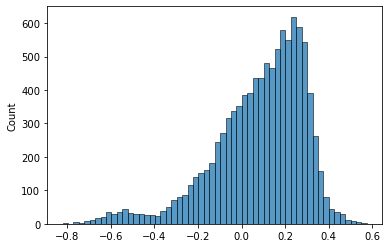

In [273]:
sns.histplot(np.array(means))

In [274]:
print(' Brightness STD: ', np.std(means), '\n Brightness Mean: ', np.mean(means))

 Brightness STD:  0.20896606 
 Brightness Mean:  0.081421226


## Train Model

In [275]:
dataset = DataModule('imgs/', './train.xlsx', './test.xlsx')
dataset.prepare_data()

In [276]:
dataset.train_data.dataset.groupby(['Nodule/Mass', 'Abnormal']).count()

Unnamed: 0  image_id
Nodule/Mass Abnormal                      
0           0               7045      7045
            1               2418      2418
1           1                537       537

In [277]:
num_pos = dataset.train_data.dataset['Nodule/Mass'].sum()
num_neg = len(dataset.train_data.dataset['Nodule/Mass']) - num_pos
pos_weight = torch.Tensor([num_neg / num_pos])

In [278]:
model = Classifier(pos_weight=pos_weight)

In [279]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="models/validation/",
    filename="final-{epoch:02d}-{val_loss:.2f}",
    save_top_k=5,
    mode="min",
)

In [280]:
################ TRAINING CHANGED TO 20 EPOCHS
trainer = pl.Trainer(callbacks=[checkpoint_callback], checkpoint_callback=True, max_epochs=20, logger=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [281]:
trainer.fit(model, dataset.train_dataloader(), dataset.val_dataloader())
trainer.save_checkpoint("models/final_model.ckpt")


  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | BCELoss | BCEWithLogitsLoss | 0     
2 | sigmoid | Sigmoid           | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  83%|████████▎ | 417/501 [32:56<06:37,  4.73s/it, loss=1.59, v_num=17] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|████████▎ | 417/501 [41:04<08:15,  5.90s/it, loss=1.5, v_num=17]  
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|████████▎ | 417/501 [30:17<06:05,  4.35s/it, loss=1.01, v_num=17] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|████████▎ | 417/501 [30:15<06:04,  4.34s/it, loss=1.01, v_num=17] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|████████▎ | 417/501 [30:10<06:03,  4.33s/it, loss=0.954, v_num=17]
Validating: 0it [00:00, ?it/s]
Epoch 5:  83%|████████▎ | 417/501 [30:18<06:05,  4.35s/it, loss=0.93, v_num=17]  
Validating: 0it [00:00, ?it/s]
Epoch 6:  83%|████████▎ | 417/501 [30:13<06:04,  4.34s/it, loss=0.796, v_num=17]
Validating: 0it [00:00, ?it/s]
Epoch 7:  83%|████████▎ | 417/501 [30:29<06:07,  4.38s/it, loss=0.758, v_num=17] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  83%|████████▎ | 417/501 [30:13<06:04,  4.34s/it, loss=0.709, v_num=17] 
Validating: 0it [00:

/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluate Model

In [285]:
trained_model = model.load_from_checkpoint('models/final_model.ckpt')

In [286]:
labels, pred_list = validate(trained_model, dataset.val_dataloader())

/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall weighted threshold:  0.25
 AUC: 0.7782761126864518 
 Precision:  [0.97541634 0.15155616] 
 Recall:  [0.66235864 0.78321678] 
 F-Score:  [0.6843218  0.55281343]


/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


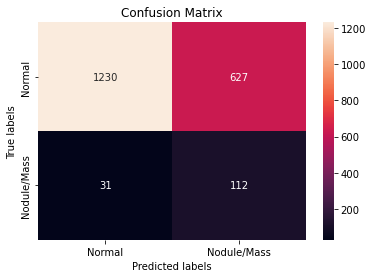

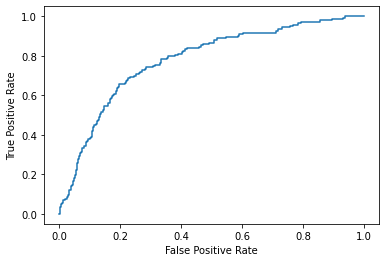

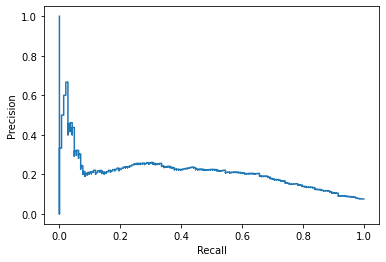

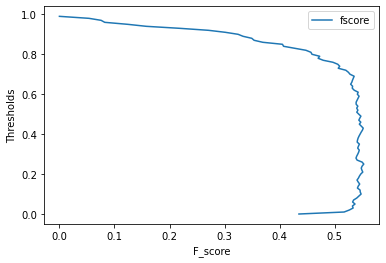

In [287]:
f_scores = []
threshold_range = np.arange(0,1,0.01)
for threshold in threshold_range:
    results = analysis(labels, pred_list, threshold=threshold, f_beta=3)
    f_scores.append(results['fscore'][1])

recall_weighted_threshold = threshold_range[np.array(f_scores).argmax()]
print('Recall weighted threshold: ', recall_weighted_threshold)

results = analysis(labels, pred_list, threshold=recall_weighted_threshold, f_beta=3)

print(' AUC:', results['auc'], '\n Precision: ', results['precision'],
      '\n Recall: ', results['recall'], '\n F-Score: ', results['fscore'])

plot_confusion_matrix(results['confusion_matrix'])

p, r, thresholds = precision_recall_curve(labels, pred_list)
roc_curve = metrics.RocCurveDisplay(fpr=results['fpr'], tpr=results['tpr'])
roc_curve.plot()

pr_display = PrecisionRecallDisplay(precision=p, recall=r).plot()
pr_display.plot()
plt.cla()
plt.plot(f_scores, threshold_range, label='fscore')
#plt.plot(adam_fpr, adam_tpr, label='Adam')
plt.ylabel('Thresholds')
plt.xlabel('F_score')
plt.legend()

/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall weighted threshold:  0.2
 AUC: 0.7972894095672771 
 Precision:  [0.97834804 0.15405046] 
 Recall:  [0.65697361 0.81118881] 
 F-Score:  [0.67928731 0.56862745]


/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


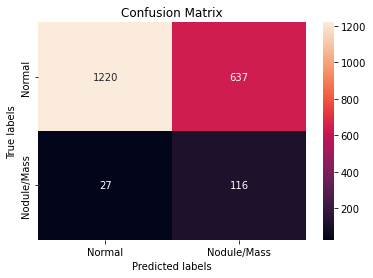

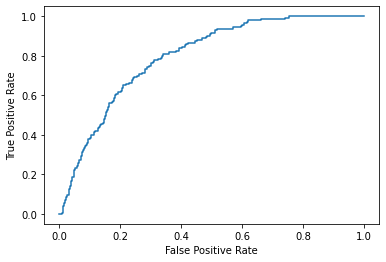

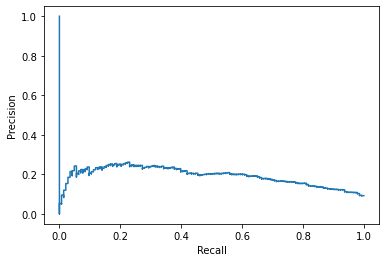

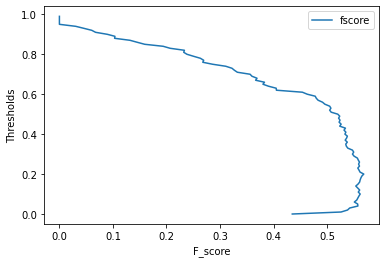

In [284]:
f_scores = []
threshold_range = np.arange(0,1,0.01)
for threshold in threshold_range:
    results = analysis(labels, pred_list, threshold=threshold, f_beta=3)
    f_scores.append(results['fscore'][1])

recall_weighted_threshold = threshold_range[np.array(f_scores).argmax()]
print('Recall weighted threshold: ', recall_weighted_threshold)

results = analysis(labels, pred_list, threshold=recall_weighted_threshold, f_beta=3)

print(' AUC:', results['auc'], '\n Precision: ', results['precision'],
      '\n Recall: ', results['recall'], '\n F-Score: ', results['fscore'])

plot_confusion_matrix(results['confusion_matrix'])

p, r, thresholds = precision_recall_curve(labels, pred_list)
roc_curve = metrics.RocCurveDisplay(fpr=results['fpr'], tpr=results['tpr'])
roc_curve.plot()

pr_display = PrecisionRecallDisplay(precision=p, recall=r).plot()
pr_display.plot()
plt.cla()
plt.plot(f_scores, threshold_range, label='fscore')
#plt.plot(adam_fpr, adam_tpr, label='Adam')
plt.ylabel('Thresholds')
plt.xlabel('F_score')
plt.legend()

## Labelling Choice

In [154]:
class CXRUntaggedDataset(Dataset):
    def __init__(self, excel_path: str = "./", img_dir: str = "./"):
        """
        Args:
            excel_path (string): Path to excel file with ids and labels.
            img_dir (string): Directory with all the png images.
        """
        self.dataset = self.prepare_dataset(excel_path)
        self.img_dir = img_dir

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])   
        
    def prepare_dataset(self, excel_path):
        df = pd.read_excel(excel_path)
        df = df.sort_values(by='image_id', ascending=False)
        df = df.drop_duplicates(subset="image_id", keep="first")
        df = df.sample(frac=1).reset_index(drop=True)
        return df
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataset['image_id'].iloc[idx] + '.png')
        image = Image.open(img_path)
        image = self.transform(image)
        uuid = self.dataset['image_id'].iloc[idx]
        return image, uuid
    
class UntaggedDataModule(pl.LightningDataModule):
    def __init__(self, img_dir: str = "./", file: str = "./", batch_size: int = 24):
        """
        Args:
            img_dir (string): Directory with all the png images.
            file (string): path to excel
            batch_size (int): batch size for training
        """
        super().__init__()
        self.img_dir = img_dir
        self.file = file
        self.batch_size = batch_size
    
    def prepare_data(self):
        self.data = CXRUntaggedDataset(self.file, self.img_dir)
        
    def dataloader(self):
        return DataLoader(self.data, batch_size=self.batch_size)

def predict(model: Classifier, data_loader: DataLoader):
    """ Generates model predictions using a dataloader
    Args:
        model (Classifier) : computer vision model generating predictions
        data_loader (DataLoader) : dataloader to iterate over dataset
    """
    uuids = []
    pred_list = []
    
    for x, y in data_loader:
        preds = model.predict(x)
        uuids += list(y)
        pred_list += list(preds.detach().cpu().numpy())
        
    return uuids, pred_list

In [156]:
dataset = UntaggedDataModule(img_dir='imgs/', file='untagged.xlsx')
dataset.prepare_data()

uuids, pred_list = predict(trained_model, dataset.dataloader())

In [156]:
# Create dataframe of logit predictions linked to uuids
preds_df = pd.DataFrame(data=pred_list, index=uuids, columns=['Logit'])
preds_df = preds_df.sort_values(['Logit'])
preds_ar = preds_df['Logit'].values

In [194]:
def nearest(array: np.array, value: float):
    """ Finds nearest value in array to given value
    Args:
        array (np.array) : array to be searched
        value (float) : value to determine closest value
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def nearest_list(array: np.array, n: int, value: float):
    """ Generate a list of n nearest values in an array, returning indices and values
    Args:
        array (np.array) : array to be searched
        n (int) : number of values to be returned
        value (float) : value to determine closest value
    """
    indices_ar = np.arange(0, len(array), 1)
    nearest_list = []
    for i in range(n):
        idx, elem_value = find_nearest(array, value)
        nearest_list.append([indices_ar[idx], elem_value])
        indices_ar = np.delete(indices_ar, idx)
        array = np.delete(array, idx)
        
    return nearest_list

In [195]:
# Calculate the nearest 300 values to threshold/decision boundary (0.16)
output = nearest_list(preds_ar, 300, recall_weighted_threshold)

# Select the 300 values from the prediction dataframe
indices_ar = np.stack(output)[:,0]
start = int(np.sort(indices_ar)[0])
end = int(np.sort(indices_ar)[-1])
tagging_df = preds_df[start:end+1]

# Output values to a json
tagging_df.to_json('uuid_list.json')